In [1]:
from matplotlib import pyplot as plt
import cv2
import numpy as np
import torch
from model import Variational_Autoencoder, Encoder, Decoder, Fusion
from model2 import Encoder_decoder
from data_loader import VAEDataset, VAEDataset1
from torch.utils.data import DataLoader
from torchsummary import summary
def convert_RGB(img, p):
    img = cv2.cvtColor(img, cv2.COLOR_YCrCb2BGR)
    #img = cv2.normalize(img, None, alpha=0.01, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_64F)
    if p:
        print(np.max(img), np.min(img))
    return img
def pyramid(ir, rgb):
    ir, rgb = [ir.cuda()], [rgb.cuda()]
    for i in range(1, DEPTH):
        ir.append(torch.nn.functional.interpolate(ir[-1], scale_factor=0.5).cuda())
        rgb.append(torch.nn.functional.interpolate(rgb[-1], scale_factor=0.5).cuda())
    return ir, rgb

In [2]:
rgb_vp = 'archive/dataset/img_raw/rgb/'
ir__vp = 'archive/dataset/img_raw/nir/'

BATCH_SIZE = 2
DEPTH = 5
val_ds = VAEDataset1(rgb_vp, ir__vp, half=False)
val_loader = DataLoader(
        dataset=val_ds,
        batch_size=BATCH_SIZE,
        num_workers=0,
        pin_memory=True,
        shuffle=True
    )
vae = Encoder_decoder(DEPTH, 1, 3).cuda()
vae.load_state_dict(torch.load("w2_edof.pth"))
vae = vae.float()
e = vae.eval()

tensor(0.4930, grad_fn=<MaxBackward1>) tensor(0.2657, grad_fn=<MinBackward1>)


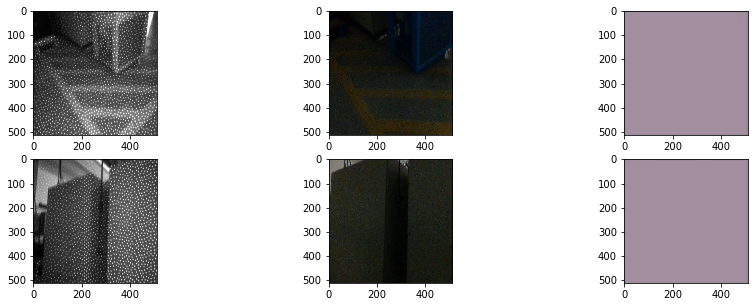

In [7]:
val_batch = next(iter(val_loader))

ir_t = val_batch[0].cuda()
rgb_t = val_batch[1].cuda()

ir_t, rgb_t = pyramid(ir_t, rgb_t)

fusion_t = vae(ir_t, rgb_t)
fusion_t = fusion_t.cpu()

print(torch.max(fusion_t), torch.min(fusion_t))

ir_array = ir_t[0].cpu().detach().numpy()
rgb_array = rgb_t[0].cpu().detach().numpy()
fusion_array = fusion_t.view(BATCH_SIZE, 3, 512, 512).cpu().detach().numpy()

ir_array = ir_array[:,0,:,:]
rgb_array = rgb_array.transpose((0,2,3,1))
fusion_array = fusion_array.transpose((0,2,3,1))



fig, ax = plt.subplots(nrows=BATCH_SIZE, ncols=3, figsize=(15, 5))
for i in range(BATCH_SIZE):
    ax[i, 0].imshow(ir_array[i], cmap='gray')
    ax[i, 1].imshow(rgb_array[i])
    #res = np.uint8(np.sqrt(np.square(cv2.cvtColor(fusion_array[i], cv2.COLOR_RGB2GRAY) - ir_array[i]))*255/15.78)
    #res = np.uint8(np.sqrt(np.square(fusion_array[i]-rgb_array[i]))*255/15.78)
    #res = 0.2989 * res[:,:,0] + 0.5870 * res[:,:,1] + 0.1140 * res[:,:,2]
    #ax[i,2].imshow(res, cmap='gray')
    ax[i, 2].imshow(fusion_array[i]*2)
    #ax[i,3].imshow(fusion_array[i,:,:,0], cmap='gray')
plt.show()

del fusion_array, rgb_array, ir_array, fusion_t, ir_t, rgb_t, val_batch